In [194]:
import pydub
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set_theme()

import diffeq_tsint as methods

Idk pac mal se igrej z metodami

In [195]:
def dT_dt(T, k, T_zun):
    return -k * (T - T_zun)

def solved_basic(t, T0, k, T_zun):
    return T_zun + np.exp(-k * t) * (T0 - T_zun)

In [196]:
def compare_abs(x,y):
    return abs(x-y)

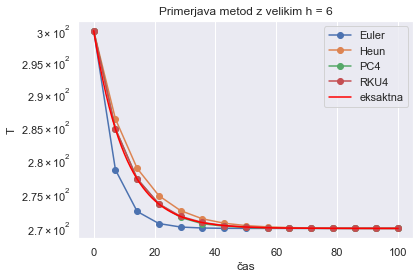

In [197]:
k = 0.1
T_zun = 270. #K, ceprov nima veze
def f(T, t): return dT_dt(T, k, T_zun)
end_t = 100
dpoints = 15
h = (end_t - 0) / dpoints

T0 = 300. #K
t = np.linspace(0, end_t, dpoints)
t_full = np.linspace(0, end_t, 100)

true_y = solved_basic(t_full, T0, k, T_zun)
def diff(x): return compare_abs(x, true_y)/true_y

plt.plot(t, (methods.euler(f, T0, t)), '-o', label='Euler')
plt.plot(t, (methods.heun(f, T0, t)), '-o', label='Heun')
plt.plot(t, (methods.pc4(f, T0, t)), '-o', label='PC4')
plt.plot(t, (methods.rku4(f, T0, t)), '-o', label='RKU4')
plt.plot(t_full, true_y, 'red', label='eksaktna')

plt.title(f'Primerjava metod z velikim h = {int(h)}')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('T')
plt.savefig("grafi/primerja_metod.pdf", bbox_inches='tight')
plt.show()

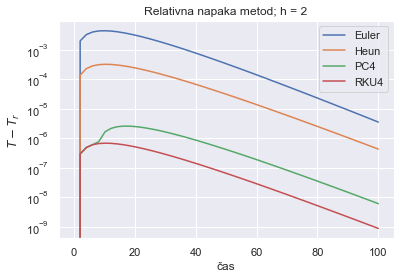

In [198]:
dpoints = 50
t = np.linspace(0, end_t, dpoints)
true_y = solved_basic(t, T0, k, T_zun)
plt.plot(t, diff(methods.euler(f, T0, t)), '-', label='Euler')
plt.plot(t, diff(methods.heun(f, T0, t)), '-', label='Heun')
plt.plot(t, diff(methods.pc4(f, T0, t)), '-', label='PC4')
plt.plot(t, diff(methods.rku4(f, T0, t)), '-', label='RKU4')
# plt.plot(t_full, true_y, 'red', label='eksaktna')

plt.title(f'Relativna napaka metod; h = {int(end_t/dpoints)}')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('$T-T_r$')
plt.savefig("grafi/relativne_napake.pdf", bbox_inches='tight')
plt.show()

Opazimo lahko, da je napaka pri vseh metodah največja nekje okoli 15s. Zanimiva in zelo relevantna analiza je, s kakšno potenco se napaka pri tej vrednosti dejansko povečuje ko spreminjamo vrednost $h$.

Če bi dovolj zmanjšal $h$, dobimo precej lep graf, kot lahko opazimo naprej.

In [199]:
def lin_fit(x,a,b):
    return x*a+b

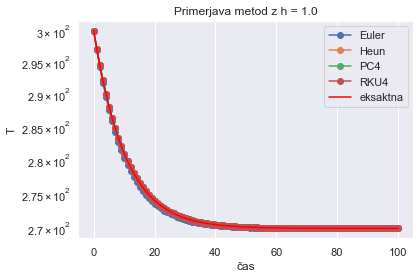

In [200]:
k = 0.1
T_zun = 270.  # K, ceprov nima veze
def f(T, t): return dT_dt(T, k, T_zun)


end_t = 100
dpoints = 100
h = (end_t - 0) / dpoints

T0 = 300.  # K
t = np.linspace(0, end_t, dpoints)
t_full = np.linspace(0, end_t, 100)

true_y = solved_basic(t_full, T0, k, T_zun)
def diff(x): return compare_abs(x, true_y)/true_y


plt.plot(t, (methods.euler(f, T0, t)), '-o', label='Euler')
plt.plot(t, (methods.heun(f, T0, t)), '-o', label='Heun')
plt.plot(t, (methods.pc4(f, T0, t)), '-o', label='PC4')
plt.plot(t, (methods.rku4(f, T0, t)), '-o', label='RKU4')
plt.plot(t_full, true_y, 'red', label='eksaktna')

plt.title(f'Primerjava metod z h = {round(h,2)}')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('T')
plt.savefig("grafi/primerjava_mali_h.pdf", bbox_inches='tight')

plt.show()


## Ćasovna zahtevnost

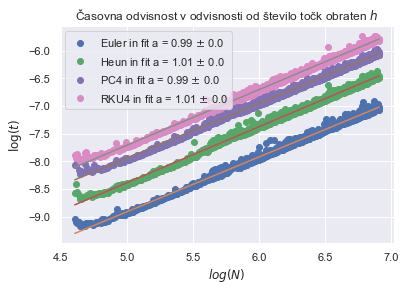

In [250]:
x_max = 15  # nima zares veze kero uzams, vazn da lah primerjas pac
# hs = np.linspace(1e-3, 1e-1, 100)

ns = np.int16(np.arange(1e2, 1e3))

k = 0.1
T_zun = 270.  # K, ceprov nima veze
def f(T, t): return dT_dt(T, k, T_zun)

end_t = x_max
dpoints = 15
T0 = 300.  # K

euler = np.empty_like(ns, dtype=float)
heun = np.empty_like(ns, dtype=float)
pc4 = np.empty_like(ns, dtype=float)
rku4 = np.empty_like(ns, dtype=float)

for i in range(len(ns)):
    # t = np.arange(0, end_t, hs[i])
    t = np.linspace(0, end_t, num=ns[i])
    # print(t)
    true_y = solved_basic(t, T0, k, T_zun)

    start = time.time()
    methods.euler(f, T0, t)
    euler[i] = time.time()-start

    start = time.time()
    methods.heun(f, T0, t)
    heun[i] = time.time()-start

    start = time.time()
    methods.pc4(f, T0, t)
    pc4[i] = time.time()-start

    start = time.time()
    methods.rku4(f, T0, t)
    rku4[i] = time.time()-start

    # heun[i] = np.abs(true_y[-1] - methods.heun(f, T0, t)[-1])
    # pc4[i] = np.abs(true_y[-1] - methods.pc4(f, T0, t)[-1])
    # rku4[i] = np.abs(true_y[-1] - methods.rku4(f, T0, t)[-1])


def koef_and_draw(ns, data, name):
    x = np.log(ns)
    y = np.log(data)

    # non_inf = np.argmax(y != -np.inf)

    # x, y = x[non_inf:], y[non_inf:]

    popt, pcov = optimize.curve_fit(lin_fit, x, y)
    errs = np.sqrt(np.diag(pcov))

    a = popt[0], errs[0]

    plt.plot(
        x, y, 'o', label=f'{name} in fit a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    # , label=f'{name} fit; a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    plt.plot(x, lin_fit(x, *popt))


koef_and_draw(ns, euler, 'Euler')
koef_and_draw(ns, heun, 'Heun')
koef_and_draw(ns, pc4, 'PC4')
koef_and_draw(ns, rku4, 'RKU4')
plt.legend()
plt.title("Časovna odvisnost v odvisnosti od število točk obraten $h$")
plt.xlabel("$log(N)$")
plt.ylabel("$\log(t)$")
plt.savefig("grafi/casovna.pdf", bbox_inches='tight')
plt.show()


In [ ]:
start = time.time()
time.time() - start

Že če damo $h = 1$ se grafi skoraj popolnoma ujemajo, kar pomeni, da metode znajo rešiti to vrednos (so stabilne).

## Napake

/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_35623/511531127.py:30: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_35623/511531127.py:30: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_35623/511531127.py:30: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_35623/511531127.py:30: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)


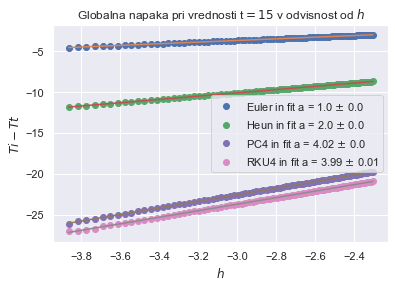

In [215]:
x_max = 15 #nima zares veze kero uzams, vazn da lah primerjas pac
hs = np.linspace(1e-3, 1e-1, 100)

k = 0.1
T_zun = 270.  # K, ceprov nima veze
def f(T, t): return dT_dt(T, k, T_zun)
end_t = x_max
dpoints = 15
T0 = 300.  # K

def diff_scalar(x,y): return np.abs(x-y)

euler = np.zeros_like(hs)
heun = np.zeros_like(hs)
pc4 = np.zeros_like(hs)
rku4 = np.zeros_like(hs)

for i in range(20, len(hs)):
    t = np.arange(0, end_t, hs[i])
    true_y = solved_basic(t, T0, k, T_zun)
    euler[i] = np.abs(true_y[-1] - methods.euler(f, T0, t)[-1])
    heun[i] = np.abs(true_y[-1] - methods.heun(f, T0, t)[-1])
    pc4[i] = np.abs(true_y[-1] - methods.pc4(f, T0, t)[-1])
    rku4[i] = np.abs(true_y[-1] - methods.rku4(f, T0, t)[-1])



def koef_and_draw(hs, data, name):
    x = np.log(hs)
    y = np.log(data)

    non_inf = np.argmax(y != -np.inf)
    
    x, y = x[non_inf:], y[non_inf:]

    popt, pcov = optimize.curve_fit(lin_fit, x, y)
    errs = np.sqrt(np.diag(pcov))

    a = popt[0], errs[0]

    plt.plot(x, y, 'o', label=f'{name} in fit a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    plt.plot(x, lin_fit(x,*popt))#, label=f'{name} fit; a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')

koef_and_draw(hs, euler, 'Euler')
koef_and_draw(hs, heun, 'Heun')
koef_and_draw(hs, pc4, 'PC4')
koef_and_draw(hs, rku4, 'RKU4')
plt.legend()
plt.title("Globalna napaka pri vrednosti t$ = 15$ v odvisnost od $h$")
plt.xlabel("$h$")
plt.ylabel("$Ti - Tt$")
plt.savefig("grafi/globalne_napake.pdf", bbox_inches='tight')
plt.show()


In [202]:
# x_max = 15  # nima zares veze kero uzams, vazn da lah primerjas pac
# hs = np.linspace(1e-3, 1e-1, 10)

# k = 0.1
# T_zun = 270.  # K, ceprov nima veze
# def f(T, t): return dT_dt(T, k, T_zun)


# end_t = x_max
# dpoints = 15
# T0 = 300.  # K


# def diff_scalar(x, y): return np.abs(x-y)


# euler = np.zeros((len(hs), 2))
# heun = np.zeros((len(hs), 2))
# pc4 = np.zeros((len(hs), 2))
# rku4 = np.zeros((len(hs), 2))

# for i in range(20, len(hs)):
#     t = np.arange(0, end_t, hs[i])
#     true_y = solved_basic(t, T0, k, T_zun)
#     euler[i] = np.abs(true_y[-1] - methods.euler(f, T0, t)[-2:])
#     heun[i] = np.abs(true_y[-1] - methods.heun(f, T0, t)[-2:])
#     pc4[i] = np.abs(true_y[-1] - methods.pc4(f, T0, t)[-2:])
#     rku4[i] = np.abs(true_y[-1] - methods.rku4(f, T0, t)[-2:])


# def local_err(hs, data, name):
#     print(hs,data)
#     x = np.log(hs)
#     y = np.log(data[:, 1] - data[:, 0])

#     # print(x.shape, y.shape)

#     x = x[np.isfinite(y)]
#     y = y[np.isfinite(y)]

#     # non_inf = np.argmax(np.isnan(y))
#     # # y = np.log(data)
#     # x, y = x[non_inf:], y[non_inf:]
#     print(x,y)
#     popt, pcov = optimize.curve_fit(lin_fit, x, y)
#     errs = np.sqrt(np.diag(pcov))
#     a = popt[0], errs[0]
#     plt.plot(
#         x, y, 'o', label=f'{name}; a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')


# local_err(hs, euler, 'Euler')
# local_err(hs, heun, 'Heun')
# local_err(hs, pc4, 'PC4')
# local_err(hs, rku4, 'RKU4')
# plt.legend()
# plt.title("Globalna napaka pri vrednosti t$ = 15$ v odvisnost od $h$")
# plt.xlabel("$h$")
# plt.ylabel("$Ti - Tt$")
# plt.show()


Graf prikazuje, da so napake zares pravilne oblike, kot smo jih napovedali pri teoretični napovedi.
Torej
TUKI NARED TABELCO

opazi pa se tudi, da je seveda napaka pri RKU4 in PC4 precej manjša nepresenetljivost bistveno manjša pri vsaki vrednosti, in tudi natančna na bolj natančen polinomski razvoj. Eurlerjevo metodo je smiselno uporabljati zgolj, če imamo zelo zelo veliko podatkov (ker ima linearno zahtevnost) in je funkcije zelo pohlevna, kar pomeni, da jo bomo res dobro zadeli tudi z večjimi $h$, ali pa če nam je važna samo hitrost programa ne pa tudi kakšna je natančnost (seveda govorim do neke mere, ni ravno smiselno, da je napaka več kot 100 odstotna).

## Stabilnost

Stabilnost sem implementiral tako, da sem pogledal zadnjih nekaj členov ter jih primerjal, da je njihova skupna vsota absolutnih vrednosti manjša kot neka vrednost (postavil sem na 0.01, ker nas zanimajo zgolj vrednosti, ki precej odstopajo - težko odstopajo malo).

Zanima nas torej, kakšen je največji koeficient $kh$ do katerega enačbe še delujejo.

Najprej je fino pokazat kaj se zgodi, če ni stabilno - oziroma, kaj pomeni, da ni stabilno. Pri fiksnem $k$ lahko to dosežemo s spreminjanjem $h$.

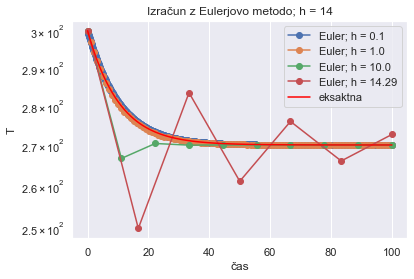

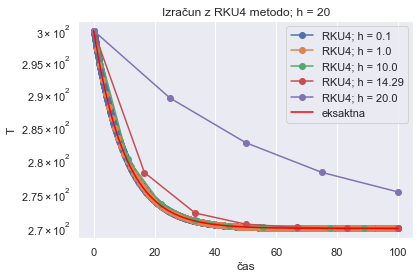

In [203]:
k = 0.1
T_zun = 270.  # K, ceprov nima veze
def f(T, t): return dT_dt(T, k, T_zun)

for points in [1000, 100, 10, 7]:

    end_t = 100
    h = (end_t - 0) / points

    T0 = 300.  # K
    t = np.linspace(0, end_t, points)
    t_full = np.linspace(0, end_t, 100)

    true_y = solved_basic(t_full, T0, k, T_zun)
    def diff(x): return compare_abs(x, true_y)/true_y
    plt.plot(t, (methods.euler(f, T0, t)), '-o',
             label=f'Euler; h = {round(h, 2)}')
    # plt.plot(t, (methods.rku4(f, T0, t)), '-o',
    #          label=f'RKU4; h = {round(h, 2)}')

plt.plot(t_full, true_y, 'red', label='eksaktna')

plt.title(f'Izračun z Eulerjovo metodo; h = {int(h)}')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('T')
plt.savefig("grafi/euler_stabilnost.pdf", bbox_inches='tight')
plt.show()

for points in [1000, 100, 10, 7, 5]:
    end_t = 100
    h = (end_t - 0) / points

    T0 = 300.  # K
    t = np.linspace(0, end_t, points)
    t_full = np.linspace(0, end_t, 100)

    true_y = solved_basic(t_full, T0, k, T_zun)
    def diff(x): return compare_abs(x, true_y)/true_y
    # plt.plot(t, (methods.euler(f, T0, t)), '-o',
    #          label=f'Euler; h = {round(h, 2)}')
    plt.plot(t, (methods.rku4(f, T0, t)), '-o',
             label=f'RKU4; h = {round(h, 2)}')

plt.plot(t_full, true_y, 'red', label='eksaktna')

plt.title(f'Izračun z RKU4 metodo; h = {int(h)}')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('T')
plt.savefig("grafi/rku4_stabilnost.pdf", bbox_inches='tight')
plt.show()


Pri tem je seveda precej smiselno povdariti, da se že zelo hitro vidi, da mora biti nek smiseln $h$ drugače metoda zares nima nekega smisla. Seveda bomo dobili slabo odvisnost z vsako metodo, će bo $h$ prevelik.

In [204]:
x_max = 110  # nima zares veze kero uzams, vazn da lah primerjas pac
hs = np.linspace(1e-3, 10, 100)
k = 1
T_zun = 270.  # K, ceprov nima veze
def f(T, t): return dT_dt(T, k, T_zun)


end_t = x_max
dpoints = 15
T0 = 300.  # K


def diff_scalar(x, y): return np.abs(x-y)

y_samples = 10

# euler = np.zeros((len(hs), y_samples))
# heun = np.zeros((len(hs), y_samples))
# pc4 = np.zeros((len(hs), y_samples))
# rku4 = np.zeros((len(hs), y_samples))

euler = False
heun = False
pc4 = False
rku4 = False
threshold = 0.01

for i in range(len(hs)):
    t = np.arange(0, end_t, hs[i])
    true_y = solved_basic(t, T0, k, T_zun)



    if not euler and np.sum(np.abs(true_y[-y_samples:] - methods.euler(f, T0, t)[-y_samples:])) > threshold:
        euler = hs[i]
    if not heun and np.sum(np.abs(true_y[-y_samples:] - methods.heun(f, T0, t)[-y_samples:])) > threshold:
        heun = hs[i]
    if not pc4 and np.sum(np.abs(true_y[-y_samples:] - methods.pc4(f, T0, t)[-y_samples:])) > threshold:
        pc4 = hs[i]
    if not rku4 and np.sum(np.abs(true_y[-y_samples:] - methods.rku4(f, T0, t)[-y_samples:])) > threshold:
        rku4 = hs[i]

print(euler, heun, pc4, rku4)

1.92 1.819 1.213 2.6270000000000002


Iz tega lahko sestavimo tabelo

\begin{table}[]
\begin{tabular}{lll}
metoda & $o(h)_{globalna}$ & $hk_max$ \\
Euler  & 1                 & 1.92     \\
Heun   & 2                 & 1.819    \\
PC4    & 4.02              & 1.213    \\
RKU4   & 3.99              & 2.62    
\end{tabular}
\end{table}

ki prikazuje globalno napako pri zadnji vrednosti in maksimalen produkt $hk$ do katerega je enačba še stabilna.
Kaj tabela v praksi pomeni? Da moramo izbrati za nek določen $h$ ali $k$ izbrati nek $k$ oziroma $h$, da bo skupen produkt manjši od vrednosti v tabeli, drugače bomo dobili popolnoma napaćen rezultat.

## Dodatna

In [205]:
def dodatna_dT_dt(T, t, k, T_zun, A, delta):
    return k * (T_zun - T) + A * np.sin(2*np.pi/24 * (t-delta))

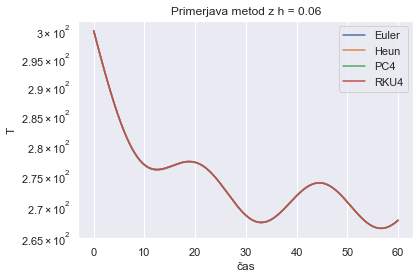

In [206]:
k = 0.1
T_zun = 270.  # K, ceprov nima veze
def f(T, t): return dodatna_dT_dt(T, t, k, T_zun, 1, 10)


end_t = 60
dpoints = 1000
h = (end_t - 0) / dpoints

T0 = 300.  # K
t = np.linspace(0, end_t, dpoints)
t_full = np.linspace(0, end_t, 100)

plt.plot(t, (methods.euler(f, T0, t)), '-', label='Euler')
plt.plot(t, (methods.heun(f, T0, t)), '-', label='Heun')
plt.plot(t, (methods.pc4(f, T0, t)), '-', label='PC4')
plt.plot(t, (methods.rku4(f, T0, t)), '-', label='RKU4')

plt.title(f'Primerjava metod z h = {round(h, 2)}')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('T')
plt.savefig("grafi/dodatna_graf.pdf", bbox_inches='tight')
plt.show()


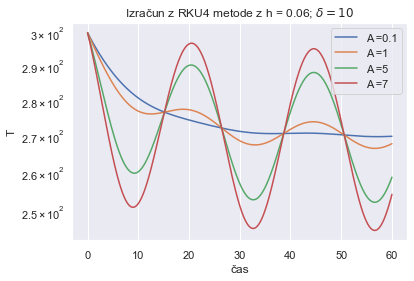

In [207]:
for a in [0.1, 1, 5, 7]:
    k = 0.1
    T_zun = 270.  # K, ceprov nima veze
    def f(T, t): return dodatna_dT_dt(T, t, k, T_zun, a, 10)

    end_t = 60
    dpoints = 1000
    h = (end_t - 0) / dpoints

    T0 = 300.  # K
    t = np.linspace(0, end_t, dpoints)
    t_full = np.linspace(0, end_t, 100) 

    plt.plot(t, (methods.rku4(f, T0, t)), '-', label=f'A ={a}')

plt.title(f'Izračun z RKU4 metode z h = {round(h, 2)}; $\delta = 10$')
plt.yscale('log')
plt.legend()
plt.xlabel('čas')
plt.ylabel('T')
plt.savefig("grafi/dodatna_graf_velik_a.pdf", bbox_inches='tight')
plt.show()


Kako izračunati kje je vrh? Najbolje je da vzamemo kakšno metodo, ki ima čim manjšo napako v $y$ smeri in izberemo čim večji $A$, da bo napaka v $y$ čim manjša.. Čisto dovolj primerjna je naprimer RKU4 metoda, ki nam seveda poda lokalno napako $o(h^5)$. Druga možnost je samo, da izračunamo vrednost z zelim majhnih $h$ (kolikor natančno pač hočemo). Če pa imamo zgolj funkcijo, pa se seveda lahko posližimo Fourierove transformacije.